In [3]:
# Import packages:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import censusdata
import re
import plotly.figure_factory as ff

/Users/Prath/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [7]:
# Save your API key as "deliverable1/api.key"
# Read in API key:
with open("api.key", "r") as my_file:
    api_key = my_file.readline() 

In [35]:
no_internet = 'B28002_013E'
internet_with_broadband = 'B28002_007E'
# get the margin of error for these variables for next time
#less_than_hs_grad = 'B06009_005E'

white = 'B02001_002E'
black = 'B02001_003E'
native_american = 'B02001_004E'
asian = 'B02001_005E'

median_income = 'B19013_001E'
total_income = 'B19025_001E'

total_population = 'B01003_001E'

race_variables = [white, black, asian, native_american]
race_column_names = ['white', 'black', 'asian', 'native american']

income_variables = [total_income, median_income]
income_column_names = ['total income', 'median_income']

demographics_column_names = race_column_names + ['total population', 'no internet access', 'internet with broadband subscription'] + income_column_names 
variables = race_variables + [total_population] + [no_internet] + [internet_with_broadband] + income_variables

In [37]:
mass_block_group_data = censusdata.download(src="acs5",
                                            year=2019, geo=censusdata.censusgeo([("state", '25'),
                                                                                 ("county", "*"),
                                                                                 ("block group", "*")]),
                                            key=api_key, var=variables)

In [67]:
mass_data = pd.DataFrame.copy(mass_block_group_data, deep=True)

mass_data.columns = demographics_column_names
new_indices = []
block_groups = []
tracts = []
c_name = []
for index in mass_data.index.tolist():
    new_index = str(index).split(',')[0].replace("Block Group", "")
    tract = str(index).split(',')[1].replace("Census Tract", "")
    cname = str(str(index).split(',')[2]).strip()
    new_indices.append(new_index)
    tracts.append(tract)
    block_groups.append("Block Group " + new_index)
    c_name.append(cname)

mass_data.index = new_indices
mass_data['mean income'] = round(mass_data['total income'].div(mass_data['total population']))
mass_data['median_income'] = np.where((mass_data.median_income < 0), 'NaN',mass_data.median_income)
mass_data['census tract'] = tracts
mass_data['block group'] = block_groups
mass_data['county'] = c_name
mass_data['% no internet'] = mass_data['no internet access'].div(mass_data['total population'])
mass_data['% internet with broadband subscription'] = mass_data['internet with broadband subscription'].div(mass_data['total population'])
mass_data = mass_data[mass_data['mean income'] > 0]
mass_data = mass_data.dropna().sort_values(['% no internet'], ascending=False)


display(mass_data)

,white,black,asian,native american,total population,no internet access,internet with broadband subscription,total income,median_income,mean income,census tract,block group,county,% no internet,% internet with broadband subscription
1,337,18,59,0,501,226,71,9333800.0,17358,18630.0,3124,Block Group 1,Middlesex County,0.451098,0.141717
2,275,129,0,0,472,192,189,8967100.0,12841,18998.0,7315,Block Group 2,Worcester County,0.406780,0.400424
1,842,53,0,0,1248,490,170,19041400.0,15481,15258.0,2511,Block Group 1,Essex County,0.392628,0.136218
2,388,38,0,0,581,199,109,11171500.0,15777,19228.0,6411.01,Block Group 2,Bristol County,0.342513,0.187608
3,74,265,0,6,411,135,95,6314200.0,9185,15363.0,806.01,Block Group 3,Suffolk County,0.328467,0.231144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,1806,0,383,0,2228,0,745,164532800.0,195583,73848.0,3651,Block Group 2,Middlesex County,0.000000,0.334381
4,1404,22,28,0,1502,0,700,158521400.0,113713,105540.0,201.01,Block Group 4,Suffolk County,0.000000,0.466045
3,1134,57,180,0,1389,0,543,56523200.0,82009,40693.0,4180.02,Block Group 3,Norfolk County,0.000000,0.390929
3,1314,0,101,0,1500,0,447,141729300.0,250001,94486.0,3385,Block Group 3,Middlesex County,0.000000,0.298000


In [68]:
new_race_column_names = ['% ' + race for race in race_column_names]

for index in range(len(new_race_column_names)):
    mass_data[new_race_column_names[index]] = round(mass_data[race_column_names[index]].div(mass_data['total population'])*100,1)
mass_data = mass_data.drop(columns = demographics_column_names)
cols = mass_data.columns.tolist()
cols = cols[1:3] + cols[3:] + [cols[0]]
mass_data = mass_data[cols]
mass_data['% internet with broadband subscription'] = mass_data['% internet with broadband subscription'].div(.01)
mass_data['% no internet'] = mass_data['% no internet'].div(.01)

In [84]:
county_names = ['Suffolk County', 'Middlesex County', 'Barnstable County', 'Essex County', 'Norfolk County', \
                'Berkshire County', 'Plymouth County', \
                'Bristol County', 'Hampden County', 'Franklin County', 'Worcester County', 'Hampshire County']
county_tables = []

for county in county_names:
    county_info = pd.DataFrame.copy(mass_data[mass_data['county'] == county],deep=True)
    county_tables.append(county_info)

for i,c in enumerate(county_tables):
    c = c.drop(columns='county')
    print(county_names[i], "Demographics and Internet Information")
    display(c[:10])

Suffolk County Demographics and Internet Information


,census tract,block group,% no internet,% internet with broadband subscription,% white,% black,% asian,% native american,mean income
3,806.01,Block Group 3,32.846715,23.114355,18.0,64.5,0.0,1.5,15363.0
1,1404,Block Group 1,27.230047,18.153365,17.1,75.1,0.0,4.1,22420.0
1,813,Block Group 1,27.223354,19.008826,28.1,29.7,1.7,0.0,16593.0
2,705,Block Group 2,24.448217,38.539898,10.2,10.5,55.0,5.1,26183.0
4,922,Block Group 4,22.737307,24.944812,40.6,37.5,1.5,0.0,33179.0
2,817,Block Group 2,22.244290,27.706058,5.4,78.3,1.4,0.0,35839.0
1,901,Block Group 1,21.917808,17.727639,7.3,58.7,0.0,0.0,17142.0
3,916,Block Group 3,21.064815,23.379630,35.4,4.2,60.4,0.0,22623.0
1,817,Block Group 1,20.449438,13.483146,2.9,60.7,0.0,0.0,11740.0
7,1701,Block Group 7,19.322344,21.428571,68.5,4.7,2.7,0.0,23943.0


Middlesex County Demographics and Internet Information


,census tract,block group,% no internet,% internet with broadband subscription,% white,% black,% asian,% native american,mean income
1,3124,Block Group 1,45.109780,14.171657,67.3,3.6,11.8,0.0,18630.0
1,3883,Block Group 1,31.295201,15.910585,67.6,3.7,12.0,0.0,8671.0
2,3143.01,Block Group 2,28.000000,18.400000,62.7,16.6,16.3,0.0,25954.0
2,3119,Block Group 2,26.457399,24.065770,60.7,6.4,19.7,2.2,16359.0
1,3104,Block Group 1,20.833333,12.500000,80.3,9.7,9.9,0.0,15540.0
1,3101,Block Group 1,19.166057,10.460863,63.4,20.6,7.5,0.6,12294.0
1,3507,Block Group 1,18.755981,30.526316,84.9,4.5,1.7,0.0,41172.0
1,3515,Block Group 1,18.452381,41.468254,60.5,4.2,17.5,0.0,42984.0
6,3418,Block Group 6,18.386243,31.746032,77.9,6.1,16.0,0.0,17035.0
1,3112,Block Group 1,17.984361,20.590791,37.4,14.2,38.8,1.0,18603.0


Barnstable County Demographics and Internet Information


,census tract,block group,% no internet,% internet with broadband subscription,% white,% black,% asian,% native american,mean income
3,140.02,Block Group 3,26.227390,33.462532,100.0,0.0,0.0,0.0,39367.0
3,114,Block Group 3,24.516129,16.774194,100.0,0.0,0.0,0.0,84682.0
3,148,Block Group 3,21.005677,24.412003,93.1,1.3,1.0,0.8,33508.0
1,148,Block Group 1,20.345253,31.196054,83.4,0.7,3.1,8.9,46214.0
3,149,Block Group 3,19.724771,34.097859,85.3,7.8,2.3,0.0,40674.0
1,114,Block Group 1,19.354839,42.521994,100.0,0.0,0.0,0.0,52023.0
3,153,Block Group 3,17.852835,30.639324,73.2,11.8,11.1,0.0,24298.0
2,101,Block Group 2,16.367713,42.152466,92.2,4.0,1.6,0.0,61833.0
3,116,Block Group 3,16.083916,35.139860,100.0,0.0,0.0,0.0,39176.0
2,153,Block Group 2,15.450644,28.397711,84.8,11.4,0.0,0.0,27053.0


Essex County Demographics and Internet Information


,census tract,block group,% no internet,% internet with broadband subscription,% white,% black,% asian,% native american,mean income
1,2511,Block Group 1,39.262821,13.621795,67.5,4.2,0.0,0.0,15258.0
1,2069,Block Group 1,28.383706,27.201051,78.3,17.1,0.0,2.9,18466.0
3,2069,Block Group 3,26.109391,39.834881,64.0,32.6,0.0,0.0,14791.0
3,2532.02,Block Group 3,22.548121,25.022915,90.0,1.3,5.3,0.0,31953.0
3,2082,Block Group 3,22.056921,34.282018,88.4,4.6,5.3,0.0,40126.0
1,2501,Block Group 1,21.835116,22.869955,49.7,6.1,0.0,0.6,23369.0
2,2511,Block Group 2,20.703125,15.364583,42.1,15.1,0.0,0.0,18134.0
2,2047.01,Block Group 2,20.146765,20.613742,58.8,13.1,6.5,0.0,22139.0
2,2601,Block Group 2,20.098039,19.747899,79.3,11.1,2.2,0.0,18110.0
1,2070,Block Group 1,19.757174,24.613687,47.0,27.6,0.0,0.0,18697.0


Norfolk County Demographics and Internet Information


,census tract,block group,% no internet,% internet with broadband subscription,% white,% black,% asian,% native american,mean income
5,4163,Block Group 5,26.162019,26.162019,51.1,45.2,0.0,0.0,57567.0
1,4176.01,Block Group 1,23.044397,31.078224,83.7,3.2,13.1,0.0,49955.0
2,4177.01,Block Group 2,19.498290,35.689852,70.6,2.1,27.4,0.0,26364.0
1,4224,Block Group 1,19.281437,27.425150,91.3,0.0,1.8,0.0,29345.0
1,4211,Block Group 1,16.845329,24.119449,72.7,12.4,4.2,0.0,29084.0
1,4134.01,Block Group 1,15.091864,37.007874,88.1,11.8,0.0,0.0,38746.0
2,4179.01,Block Group 2,14.900662,33.869442,60.4,5.5,21.6,0.0,33955.0
4,4177.01,Block Group 4,14.769031,36.109304,63.3,4.5,29.3,0.2,33132.0
1,4173,Block Group 1,14.739884,37.861272,77.7,4.2,18.0,0.0,45351.0
4,4179.01,Block Group 4,13.728549,35.881435,45.7,0.3,45.1,0.0,26630.0


Berkshire County Demographics and Internet Information


,census tract,block group,% no internet,% internet with broadband subscription,% white,% black,% asian,% native american,mean income
4,9353,Block Group 4,28.663793,28.232759,100.0,0.0,0.0,0.0,18301.0
2,9001,Block Group 2,24.905660,29.056604,89.2,1.8,1.3,0.0,21432.0
3,9001,Block Group 3,18.911175,46.131805,83.4,4.6,0.0,0.0,42373.0
1,9213,Block Group 1,18.843120,27.519720,89.8,0.0,2.8,0.0,26829.0
6,9002,Block Group 6,18.271120,29.076621,76.4,13.0,4.3,0.0,22537.0
3,9006,Block Group 3,17.995910,20.449898,67.5,27.6,0.0,0.0,16951.0
1,9011,Block Group 1,17.173913,31.521739,100.0,0.0,0.0,0.0,30468.0
4,9121,Block Group 4,16.932907,28.913738,97.6,1.1,0.0,0.0,24620.0
5,9009,Block Group 5,15.221239,51.504425,97.5,2.5,0.0,0.0,93983.0
1,9001,Block Group 1,14.226519,39.779006,76.8,12.3,1.5,0.0,21339.0


Plymouth County Demographics and Internet Information


,census tract,block group,% no internet,% internet with broadband subscription,% white,% black,% asian,% native american,mean income
3,5108,Block Group 3,25.173210,16.974596,28.3,71.7,0.0,0.0,10533.0
1,5112,Block Group 1,25.075834,20.222447,40.6,37.1,0.0,0.0,18236.0
5,5105.02,Block Group 5,24.978760,37.638063,57.5,37.9,0.0,1.4,30963.0
2,5105.02,Block Group 2,23.349894,20.227111,22.7,59.4,0.0,0.0,18001.0
1,5305,Block Group 1,20.845921,34.592145,99.8,0.2,0.0,0.0,30827.0
3,5453,Block Group 3,19.708029,32.992701,97.7,2.3,0.0,0.0,38226.0
3,5109,Block Group 3,19.092332,12.989045,37.1,48.0,0.8,0.0,11006.0
3,5116,Block Group 3,17.300233,19.705198,26.5,70.2,0.9,0.0,21593.0
1,5109,Block Group 1,16.883117,26.298701,43.8,42.9,0.0,0.0,21776.0
3,5442,Block Group 3,16.167665,29.241517,97.9,0.0,0.0,0.0,26116.0


Bristol County Demographics and Internet Information


,census tract,block group,% no internet,% internet with broadband subscription,% white,% black,% asian,% native american,mean income
2,6411.01,Block Group 2,34.251291,18.760757,66.8,6.5,0.0,0.0,19228.0
2,6402,Block Group 2,29.629630,28.104575,85.4,8.9,0.0,0.0,15034.0
1,6519,Block Group 1,28.322440,26.579521,30.3,8.1,0.0,0.0,17781.0
1,6406,Block Group 1,28.067227,24.873950,84.2,12.8,0.0,0.0,25936.0
1,6411.01,Block Group 1,27.979798,23.535354,77.1,13.3,0.0,0.0,17063.0
2,6421,Block Group 2,26.641651,15.103189,71.0,1.9,0.0,0.0,22577.0
1,6404,Block Group 1,26.509186,24.934383,88.7,7.3,0.0,0.0,37589.0
2,6527,Block Group 2,26.339969,28.483920,67.5,6.1,0.0,0.0,20233.0
2,6518,Block Group 2,26.284585,31.027668,62.5,5.9,0.0,0.0,20604.0
2,6506,Block Group 2,26.020408,12.500000,61.1,6.6,0.0,0.0,11765.0


Hampden County Demographics and Internet Information


,census tract,block group,% no internet,% internet with broadband subscription,% white,% black,% asian,% native american,mean income
2,8009,Block Group 2,31.524548,13.608958,82.0,14.6,0.0,0.0,14009.0
1,8117,Block Group 1,29.039813,29.274005,78.5,0.0,0.0,0.0,31003.0
1,8120.01,Block Group 1,28.821811,14.410906,89.0,3.5,0.0,0.0,18935.0
1,8023,Block Group 1,27.086882,13.628620,87.9,8.2,0.0,0.0,17075.0
2,8011.02,Block Group 2,26.027397,9.132420,79.2,8.2,0.0,0.0,8588.0
4,8018,Block Group 4,25.323475,17.929760,52.3,40.7,0.0,0.0,19930.0
5,8021,Block Group 5,23.048327,48.513011,67.3,1.1,13.4,0.0,33032.0
3,8001.02,Block Group 3,21.592775,13.464696,65.9,29.1,0.0,0.0,17045.0
2,8118,Block Group 2,21.508380,9.683426,97.1,1.3,0.0,0.0,16067.0
1,8011.01,Block Group 1,20.760234,25.087719,50.1,15.0,0.8,0.5,18058.0


Franklin County Demographics and Internet Information


,census tract,block group,% no internet,% internet with broadband subscription,% white,% black,% asian,% native american,mean income
4,407.01,Block Group 4,20.104439,32.114883,97.9,0.0,0.0,0.0,42906.0
1,413,Block Group 1,19.429199,29.198683,100.0,0.0,0.0,0.0,19564.0
3,404,Block Group 3,14.269142,4.640371,89.0,4.5,0.8,0.0,32244.0
3,405.02,Block Group 3,13.894888,31.605472,95.3,1.2,0.0,0.0,24714.0
2,407.01,Block Group 2,13.256007,30.985915,82.6,8.2,0.0,0.0,18634.0
4,415.02,Block Group 4,10.814249,39.058524,92.7,1.3,6.0,0.0,43130.0
1,407.02,Block Group 1,10.314875,35.287731,88.8,0.0,0.0,11.2,30777.0
3,405.01,Block Group 3,10.092961,34.528552,93.8,0.5,0.0,3.9,32651.0
1,415.01,Block Group 1,9.986684,23.701731,94.7,0.0,0.0,0.3,52493.0
2,412,Block Group 2,9.828010,27.395577,99.3,0.7,0.0,0.0,35712.0


Worcester County Demographics and Internet Information


,census tract,block group,% no internet,% internet with broadband subscription,% white,% black,% asian,% native american,mean income
2,7315,Block Group 2,40.677966,40.042373,58.3,27.3,0.0,0.0,18998.0
1,7312.03,Block Group 1,32.793807,24.349050,73.1,8.7,8.8,2.5,16195.0
1,7314,Block Group 1,21.336761,23.521851,77.9,12.5,0.0,2.2,11004.0
5,7326,Block Group 5,21.333333,20.266667,55.2,33.1,0.0,0.0,42966.0
1,7322.01,Block Group 1,20.886814,35.355893,83.0,0.0,11.1,1.3,41307.0
3,7316,Block Group 3,20.723918,33.002129,66.4,16.5,2.3,0.0,28977.0
6,7318,Block Group 6,20.070012,30.046674,64.9,14.5,7.1,0.9,13611.0
4,7304.01,Block Group 4,19.712352,20.558376,49.2,41.4,1.4,0.0,17595.0
2,7325,Block Group 2,19.413919,22.588523,77.7,6.1,4.8,0.0,17573.0
2,7107,Block Group 2,18.650794,28.174603,65.7,11.1,0.5,1.1,19979.0


Hampshire County Demographics and Internet Information


,census tract,block group,% no internet,% internet with broadband subscription,% white,% black,% asian,% native american,mean income
3,8219.03,Block Group 3,13.998704,48.282566,91.4,3.8,1.0,0.0,40839.0
2,8201.02,Block Group 2,13.976165,31.419285,100.0,0.0,0.0,0.0,24152.0
4,8224.02,Block Group 4,13.007160,36.276850,95.7,1.2,0.0,0.0,56401.0
5,8211,Block Group 5,12.997904,45.492662,99.8,0.2,0.0,0.0,38740.0
2,8214,Block Group 2,11.372064,33.745365,92.6,2.7,0.0,0.0,44212.0
1,8201.02,Block Group 1,10.570236,29.902643,93.5,4.6,0.0,0.0,33279.0
2,8227,Block Group 2,10.532544,26.627219,98.1,0.0,0.6,0.0,34204.0
1,8215,Block Group 1,9.371884,28.813559,96.5,0.4,0.0,2.2,33703.0
3,8201.02,Block Group 3,8.559201,27.627199,93.6,2.6,0.0,0.0,21770.0
2,8223,Block Group 2,8.547889,41.400618,92.8,6.0,0.0,0.0,32156.0


In [77]:
mass_data_demographics = pd.DataFrame.copy(mass_data, deep=True)
mass_data_demographics = mass_data_demographics.drop(columns=['census tract', 'block group','county'])

display(mass_data_demographics)

,% no internet,% internet with broadband subscription,% white,% black,% asian,% native american,mean income
1,45.109780,14.171657,67.3,3.6,11.8,0.0,18630.0
2,40.677966,40.042373,58.3,27.3,0.0,0.0,18998.0
1,39.262821,13.621795,67.5,4.2,0.0,0.0,15258.0
2,34.251291,18.760757,66.8,6.5,0.0,0.0,19228.0
3,32.846715,23.114355,18.0,64.5,0.0,1.5,15363.0
...,...,...,...,...,...,...,...
2,0.000000,33.438061,81.1,0.0,17.2,0.0,73848.0
4,0.000000,46.604527,93.5,1.5,1.9,0.0,105540.0
3,0.000000,39.092873,81.6,4.1,13.0,0.0,40693.0
3,0.000000,29.800000,87.6,0.0,6.7,0.0,94486.0


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def demographic_graph_reversed(df, value_vars, x_axis, title, ylabel, legend_name="Demographic"):
    """
    Produces and shows a scatterplot with trendlines, with multiple variables on the same graph.
    :param df: dataframe to be plotted.
    :param value_vars: list of column names with values to be plotted on y-axis.
    :param x_axis: column name of variable to be plotted on x-axis.
    :param xlabel: label for x-axis.
    :param ylabel: label for y-axis.
    :param legend_name: name to use for the legend.
    :param title: title of graph.
    """
    # Markers to use:
    possible_markers = ["x", "|", "_", "."]
    num_markers = len(value_vars)
    if num_markers < 5:
        markers = possible_markers[:num_markers]
    else:
        markers = "x"
    #, "axes.facecolor":"white", "figure.facecolor":"white"
    sns.set(rc={"figure.figsize":(11, 8)})
    # ID variables:
    id_vars = ["census tract", "block group"] + [x_axis]
    # print(id_vars)
    # Convert to long:
    df_melt = pd.melt(df, id_vars=id_vars, var_name=legend_name, value_name="demoValue", value_vars=value_vars)
    # Plot:, s=10 markers=["o", "*", "s", "^"]
    the_plot = sns.lmplot(x=x_axis, y="demoValue", hue=legend_name, data=df_melt, height=10, scatter_kws={"s": 50}, markers=markers)
    the_plot.set(ylabel=ylabel)
    the_plot.fig.subplots_adjust(top=0.95)
    the_plot.fig.suptitle(title)
    # To add in bivariate distribution:
    # sns.kdeplot(df_melt[x_axis], df_melt["demoValue"], hue=df_melt["demoVar"])
    plt.show()

def demographic_graph(df, value_vars, y_axis, title, xlabel, ylabel, legend_name="Demographic", ci=None, saveimage="demographic.png"):
    """
    Produces and shows a scatterplot with trendlines, with multiple variables on the same graph.
    :param df: dataframe to be plotted.
    :param value_vars: list of column names with values to be plotted on x-axis.
    :param y_axis: column name of variable to be plotted on y-axis.
    :param title: title of graph.
    :param xlabel: label for x-axis.
    :param ylabel: label for y-axis.
    :param legend_name: name to use for the legend.
    :param ci: boolean on whether confidence interval should be plotted.
    :param saveimage: file to save image to.
    """
    sns.set(font_scale=1.5)
    # Markers to use:
    markers = "."
    # possible_markers = ["x", "|", "_", "."]
    # # ["o", "*", "s", "^"]
    # num_markers = len(value_vars)
    # if num_markers < 5:
    #    markers = possible_markers[:num_markers]
    # else:
    #    markers = "x"
    # ID variables:
    id_vars = ["census tract", "block group"] + [y_axis]
    # Convert to long:
    df_melt = pd.melt(df, id_vars=id_vars, var_name=legend_name, value_name="demoValue", value_vars=value_vars)
    # Plot:
    the_plot = sns.lmplot(x="demoValue", y=y_axis, hue=legend_name, data=df_melt, height=6, aspect=1, scatter_kws={"s": 100, "alpha": 0.1}, markers=markers, ci=ci, line_kws={"linewidth": 5}, col=legend_name,)
    the_plot.set(xlabel=xlabel, ylabel=ylabel, xlim=(-5, 105), xticks=range(0, 101, 10))
    the_plot.fig.subplots_adjust(top=0.85)
    the_plot.fig.suptitle(title, fontsize="x-large")
    # the_plot._legend.remove()
    # plt.legend(markerscale=5)
    # To add in bivariate distribution:
    # sns.kdeplot(x=df_melt["demoValue"], y=df_melt[y_axis],  hue=df_melt[legend_name])
    # plt.tight_layout()
    plt.savefig(saveimage)
    plt.show()

def income_graph(df, x, y, title, xlabel, ylabel, saveimage="income_graph.png"):
    """
    Produces a scatterplot for a single group
    :param df: dataframe to be plotted.
    :param x: column name to be plotted on x-axis.
    :param y: column name to be plotted on y-axis.
    :param title: title of graph.
    :param xlabel: label for x-axis.
    :param ylabel: label for y-axis.
    """
    sns.set(rc={"figure.figsize":(14, 10)})
    the_plot = plt.scatter(df[x], df[y], alpha=0.25, c="orange")
    plt.xticks(np.arange(0, max(df[x])+10000, 10000), rotation=45)
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.tight_layout()
    plt.savefig(saveimage)
    plt.show()

In [10]:
# Get column names:
temp_names = list(mass_data)
print(temp_names)
# Grab df:
df_temp = mass_data
# Drop NAN Convert columns of interest to numeric
of_interest = ["% white", "% black", "% asian", "% native american", "% no internet", "% internet with broadband subscription", "mean income"]
for col in of_interest:
    # Drop NaN:
    df_temp = df_temp[df_temp[col] != "NaN"]
    # Convert to numeric:
    df_temp[col] = pd.to_numeric(df_temp[col])
    # Drop negative values:
    df_temp = df_temp[df_temp[col] >= 0]

['census tract', 'block group', 'county', '% no internet', '% internet with broadband subscription', '% white', '% black', '% asian', '% native american', 'mean income']


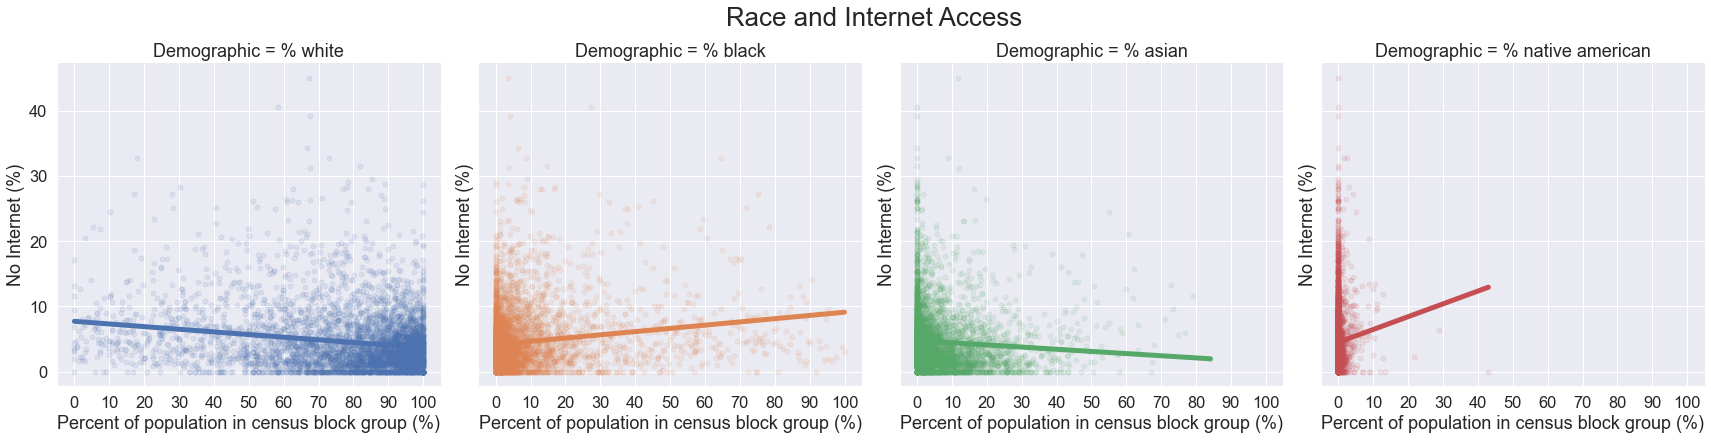

In [11]:
# Create graph:
demographic_graph(df_temp, value_vars=["% white", "% black", "% asian", "% native american"], y_axis="% no internet", title="Race and Internet Access", xlabel="Percent of population in census block group (%)", ylabel="No Internet (%)")

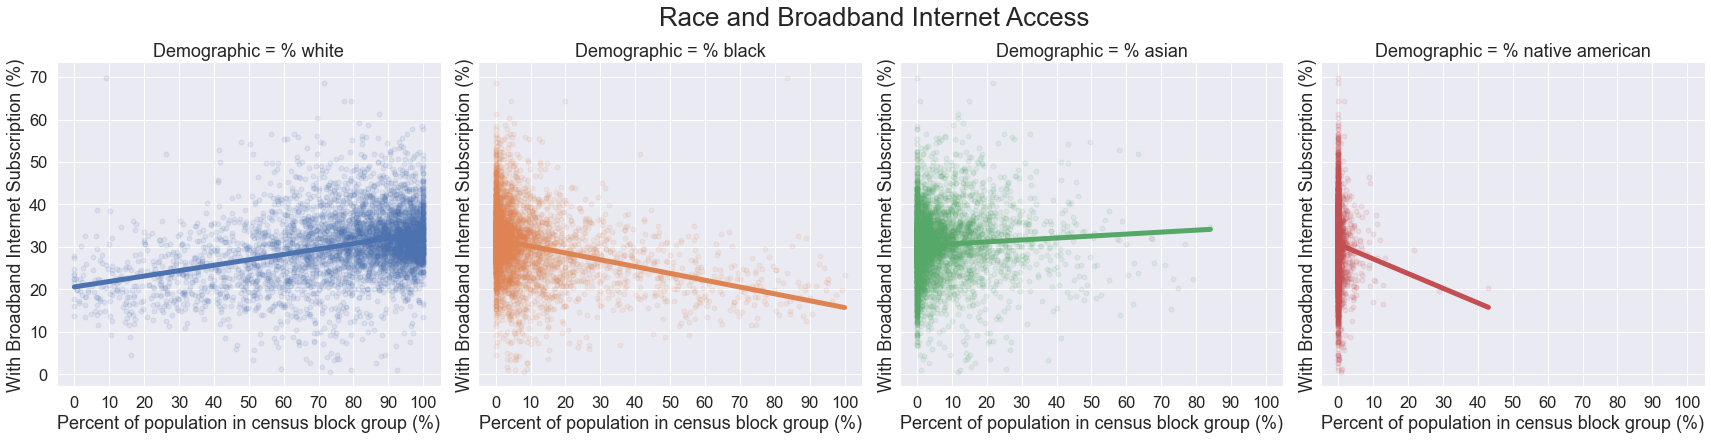

In [12]:
demographic_graph(df_temp, value_vars=["% white", "% black", "% asian", "% native american"], y_axis="% internet with broadband subscription", title="Race and Broadband Internet Access", xlabel="Percent of population in census block group (%)", ylabel="With Broadband Internet Subscription (%)", saveimage="demo_broadband.png")

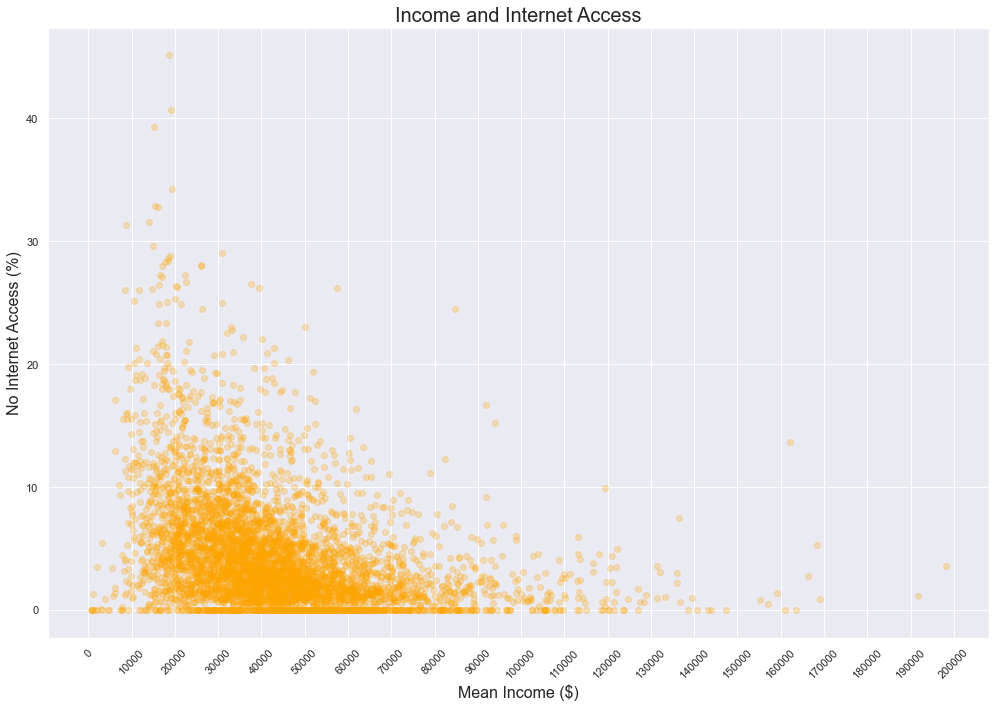

In [13]:
# Income graph:
income_graph(df_temp, x="mean income", y="% no internet", title="Income and Internet Access", xlabel="Mean Income ($)", ylabel="No Internet Access (%)")

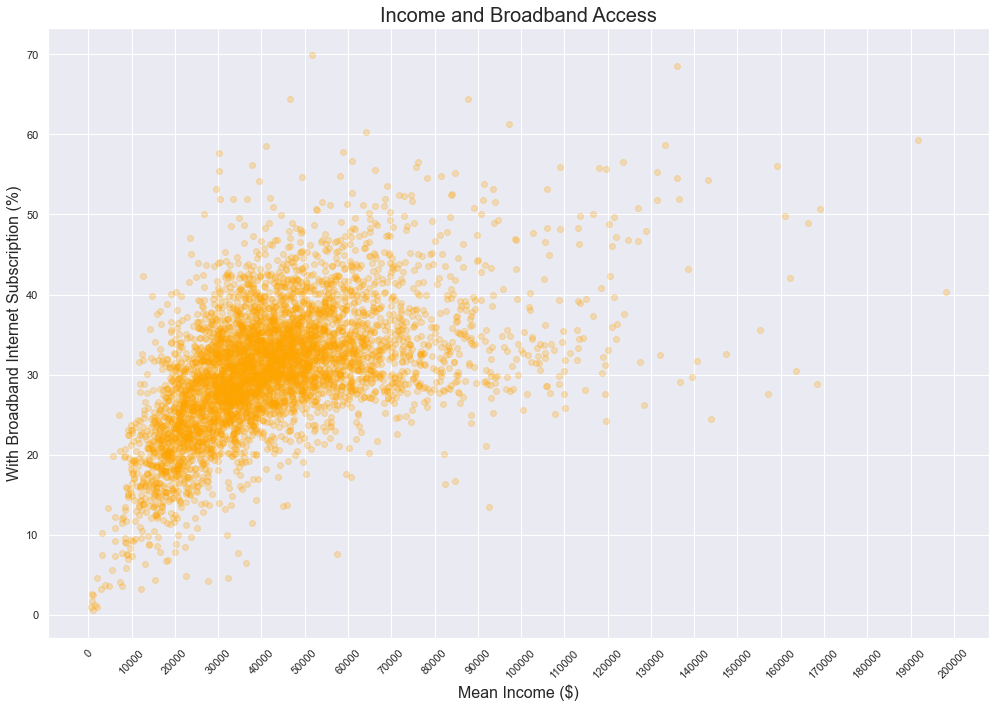

In [14]:
# Income graph:
income_graph(df_temp, x="mean income", y="% internet with broadband subscription", title="Income and Broadband Access", xlabel="Mean Income ($)", ylabel="With Broadband Internet Subscription (%)", saveimage="income_broadband.png")